Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from exercise_code.classifiers.classification_cnn import ClassificationCNN
from exercise_code.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


CIFAR-10 Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [79]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

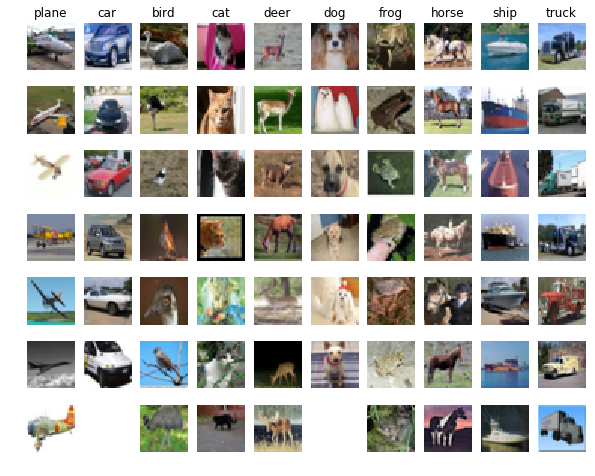

In [80]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

In [139]:
from exercise_code.classifiers.classification_cnn import ClassificationCNN

torch.manual_seed(0)
np.random.seed(0)

X = np.random.randn(2, 3, 5, 5).astype(np.float32)
X_tensor = torch.from_numpy(X.copy())
inputs = X_tensor.to(device)

model = ClassificationCNN(input_dim=(3, 5, 5), num_classes=3)
model.to(device)
outputs = model.forward(inputs)
correct_outputs = np.array([[0.0012621, -0.099135,  0.076110],
                            [0.0013608, -0.099130,  0.076120]])

# The difference should be very small. We get 1e-5
print('Difference between the correct and your forward pass:')
print(rel_error(correct_outputs, outputs.cpu().detach().numpy()))

tensor(1.00000e-02 *
       [[ 0.1262, -9.9135,  7.6110],
        [ 0.1361, -9.9130,  7.6120]])
Difference between the correct and your forward pass:
2.0824978654369382e-05


## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

In [141]:
from exercise_code.classifiers.classification_cnn import ClassificationCNN
from exercise_code.solver import Solver
from torch.utils.data.sampler import SequentialSampler

num_train = 100
OverfitSampler = SequentialSampler(range(num_train))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False, num_workers=4,
                                           sampler=OverfitSampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

overfit_model = ClassificationCNN()
overfit_model.to(device)
overfit_solver = Solver(optim_args={"lr": 1e-2})
overfit_solver.train(overfit_model, train_loader, val_loader, log_nth=1, num_epochs=10)

START TRAIN.
tensor(1.00000e-02 *
       [[-6.7403, -5.8700,  1.7349, -8.0718, -2.7664,  5.8128, -6.8095,
          7.7269, -8.2780, -4.8076],
        [-6.7468, -5.8652,  1.7369, -8.0697, -2.7669,  5.8062, -6.8117,
          7.7260, -8.2767, -4.8124],
        [-6.7435, -5.8665,  1.7332, -8.0710, -2.7697,  5.8110, -6.8088,
          7.7234, -8.2746, -4.8092],
        [-6.7479, -5.8636,  1.7351, -8.0704, -2.7671,  5.8067, -6.8058,
          7.7260, -8.2705, -4.8075],
        [-6.7415, -5.8667,  1.7302, -8.0723, -2.7629,  5.8090, -6.8071,
          7.7227, -8.2822, -4.8118],
        [-6.7450, -5.8667,  1.7350, -8.0700, -2.7688,  5.8080, -6.8091,
          7.7266, -8.2808, -4.8090],
        [-6.7440, -5.8710,  1.7338, -8.0646, -2.7704,  5.8069, -6.8072,
          7.7259, -8.2812, -4.8006],
        [-6.7415, -5.8672,  1.7312, -8.0704, -2.7640,  5.8112, -6.8050,
          7.7229, -8.2785, -4.8087],
        [-6.7418, -5.8686,  1.7359, -8.0717, -2.7657,  5.8067, -6.8096,
          7.7234, -8.2

tensor([[-1.2869,  0.0104, -0.7111, -0.4693, -0.6693,  0.5519, -0.3528,
          0.3368,  1.0455,  1.2049],
        [-1.8071,  0.0651, -1.1233, -0.5976, -1.0049,  0.7838, -0.5276,
          0.3612,  1.8668,  1.9022],
        [-1.1387, -0.0162, -0.6534, -0.4000, -0.6374,  0.4735, -0.3847,
          0.2653,  1.0205,  1.1338],
        [-1.8894,  0.2267, -1.1993, -0.5766, -1.1413,  0.8146, -0.6083,
          0.1828,  2.5572,  2.2289],
        [-0.8298, -0.0337, -0.4827, -0.3225, -0.4324,  0.3879, -0.2597,
          0.2602,  0.6524,  0.7590],
        [-1.1496, -0.0584, -0.6700, -0.4074, -0.6033,  0.4990, -0.3315,
          0.2966,  0.9544,  1.0815],
        [-1.1159, -0.0063, -0.6475, -0.3887, -0.5645,  0.5309, -0.3236,
          0.2364,  1.0555,  1.1040],
        [-0.9908,  0.0473, -0.6408, -0.3408, -0.4887,  0.4947, -0.2467,
          0.2262,  1.0026,  0.9416],
        [-1.0072, -0.0339, -0.5761, -0.3465, -0.5559,  0.4537, -0.3081,
          0.2403,  0.9082,  0.9828],
        [-0.7815, -

tensor([[-1.0001,  0.0395, -0.6218, -0.3773, -0.4939,  0.5102, -0.2875,
          0.2844,  0.8450,  0.9245],
        [-0.6267, -0.0313, -0.3466, -0.2638, -0.3259,  0.3104, -0.1950,
          0.1959,  0.5162,  0.5490],
        [-0.9704, -0.0487, -0.5636, -0.3624, -0.4921,  0.4424, -0.2780,
          0.2843,  0.7698,  0.8848],
        [-0.7982, -0.0343, -0.4568, -0.2961, -0.4293,  0.3648, -0.2564,
          0.1873,  0.7005,  0.7767],
        [-1.1317, -0.0302, -0.6098, -0.3757, -0.6616,  0.4357, -0.4210,
          0.2029,  1.1101,  1.2028],
        [-0.9974, -0.0318, -0.5632, -0.3616, -0.5129,  0.4800, -0.2966,
          0.2858,  0.8234,  0.9278],
        [-0.8117, -0.0223, -0.4464, -0.3117, -0.4685,  0.3794, -0.2911,
          0.1904,  0.7711,  0.8482],
        [-0.7999, -0.0385, -0.4403, -0.2990, -0.4108,  0.3974, -0.2263,
          0.2405,  0.6203,  0.7032],
        [-1.3775, -0.0898, -0.7712, -0.4616, -0.7412,  0.5274, -0.4522,
          0.3093,  1.1803,  1.3640],
        [-1.3493, -

tensor([[-1.2859, -0.0824, -0.7355, -0.4461, -0.6591,  0.5369, -0.3764,
          0.2898,  1.0051,  1.2019],
        [-1.2257, -0.0208, -0.6921, -0.4165, -0.6735,  0.5335, -0.3997,
          0.2480,  1.1725,  1.2466],
        [-0.8423, -0.0080, -0.4760, -0.3108, -0.4167,  0.3997, -0.2517,
          0.2224,  0.7279,  0.7660],
        [-1.2649, -0.0212, -0.7440, -0.4461, -0.6670,  0.5412, -0.4005,
          0.3224,  1.1364,  1.2513],
        [-0.9960,  0.0372, -0.6221, -0.3663, -0.5285,  0.4842, -0.2868,
          0.2441,  0.9967,  1.0102],
        [-1.3228, -0.0725, -0.7460, -0.4391, -0.7286,  0.5045, -0.4408,
          0.2874,  1.1607,  1.3384],
        [-2.1642, -0.0411, -1.2772, -0.7283, -1.1397,  0.8821, -0.6380,
          0.5344,  1.8134,  2.1408],
        [-1.4276,  0.0191, -0.8949, -0.5065, -0.6907,  0.6819, -0.3771,
          0.3916,  1.2377,  1.3390],
        [-1.1472,  0.0014, -0.6612, -0.4047, -0.6222,  0.4987, -0.3936,
          0.2781,  1.1000,  1.1669],
        [-1.4774,  

tensor([[-1.0659e+00,  2.5189e-02, -6.5927e-01, -3.6787e-01, -5.4857e-01,
          5.0077e-01, -3.0241e-01,  2.2867e-01,  1.0199e+00,  1.0148e+00],
        [-1.3188e+00,  5.3203e-02, -8.3802e-01, -4.8313e-01, -6.4976e-01,
          6.4980e-01, -3.6006e-01,  3.8154e-01,  1.1738e+00,  1.2581e+00],
        [-9.7427e-01,  3.6960e-02, -6.1678e-01, -3.5031e-01, -5.2647e-01,
          4.7171e-01, -2.8002e-01,  1.9971e-01,  1.0475e+00,  1.0086e+00],
        [-1.0163e+00, -3.6585e-02, -5.6791e-01, -3.6928e-01, -5.2665e-01,
          4.3455e-01, -3.2349e-01,  2.4171e-01,  8.7190e-01,  9.6772e-01],
        [-1.4249e+00,  5.1015e-02, -9.0993e-01, -5.0799e-01, -7.0715e-01,
          6.8991e-01, -3.6960e-01,  3.6661e-01,  1.3524e+00,  1.4148e+00],
        [-1.3682e+00,  3.3342e-02, -8.5090e-01, -5.1208e-01, -6.6704e-01,
          6.7788e-01, -3.5243e-01,  3.9947e-01,  1.2176e+00,  1.3065e+00],
        [-1.2330e+00, -3.2421e-02, -7.0890e-01, -4.2200e-01, -6.9130e-01,
          4.8558e-01, -4.1938e-0

tensor([[-0.9874, -0.0130, -0.5793, -0.3690, -0.4807,  0.4763, -0.2580,
          0.2523,  0.8557,  0.9210],
        [-0.7296, -0.0517, -0.3936, -0.2940, -0.3719,  0.3463, -0.2118,
          0.2355,  0.5168,  0.6246],
        [-0.7903,  0.0026, -0.4593, -0.3094, -0.3926,  0.4025, -0.2320,
          0.2440,  0.6342,  0.7236],
        [-0.8658,  0.0205, -0.5206, -0.3212, -0.4846,  0.4070, -0.2878,
          0.1795,  0.9025,  0.8809],
        [-1.1700, -0.0490, -0.6611, -0.4393, -0.6185,  0.4956, -0.4095,
          0.3316,  0.9593,  1.1517],
        [-1.1608, -0.0104, -0.6481, -0.3831, -0.6206,  0.4851, -0.3599,
          0.2147,  1.0818,  1.1447],
        [-1.5876,  0.0872, -1.0204, -0.5713, -0.8065,  0.7773, -0.4321,
          0.3998,  1.5933,  1.5995],
        [-0.8683, -0.0094, -0.4914, -0.3184, -0.4511,  0.3963, -0.2794,
          0.2083,  0.8052,  0.8398],
        [-0.9616, -0.0196, -0.5601, -0.3675, -0.4691,  0.4532, -0.2580,
          0.3008,  0.7232,  0.8402],
        [-1.0020,  

tensor([[-1.2869,  0.0104, -0.7111, -0.4693, -0.6693,  0.5519, -0.3528,
          0.3368,  1.0455,  1.2049],
        [-1.8071,  0.0651, -1.1233, -0.5976, -1.0049,  0.7838, -0.5276,
          0.3612,  1.8668,  1.9022],
        [-1.1387, -0.0162, -0.6534, -0.4000, -0.6374,  0.4735, -0.3847,
          0.2653,  1.0205,  1.1338],
        [-1.8894,  0.2267, -1.1993, -0.5766, -1.1413,  0.8146, -0.6083,
          0.1828,  2.5572,  2.2289],
        [-0.8298, -0.0337, -0.4827, -0.3225, -0.4324,  0.3879, -0.2597,
          0.2602,  0.6524,  0.7590],
        [-1.1496, -0.0584, -0.6700, -0.4074, -0.6033,  0.4990, -0.3315,
          0.2966,  0.9544,  1.0815],
        [-1.1159, -0.0063, -0.6475, -0.3887, -0.5645,  0.5309, -0.3236,
          0.2364,  1.0555,  1.1040],
        [-0.9908,  0.0473, -0.6408, -0.3408, -0.4887,  0.4947, -0.2467,
          0.2262,  1.0026,  0.9416],
        [-1.0072, -0.0339, -0.5761, -0.3465, -0.5559,  0.4537, -0.3081,
          0.2403,  0.9082,  0.9828],
        [-0.7815, -

tensor([[-0.8611,  0.3239,  0.5543, -1.0598,  0.6881,  0.5214,  1.2056,
          1.5117, -0.3652, -0.2046],
        [-0.5480, -0.4487,  1.1340, -0.8531, -0.0740,  0.7110,  0.1453,
          0.6329, -0.8785,  0.5061],
        [-0.6231,  0.0829,  0.6339, -1.1134,  0.3232,  0.2738,  0.5565,
          1.2632, -0.1637,  0.2823],
        [-0.3983,  0.1037,  0.6287, -0.6551,  0.4232,  0.4108,  0.6643,
          0.9474, -0.3119, -0.2530],
        [-0.6128,  0.1541,  0.2219, -0.6300,  0.1761,  0.2799,  0.6788,
          0.7032, -0.3162, -0.2443],
        [-0.4773, -0.2220,  0.6938, -0.6359, -0.0228,  0.4847,  0.1883,
          0.4484, -0.6594,  0.1663],
        [-1.5238,  0.5931,  0.6796, -1.3194,  1.5398,  0.2168,  2.9006,
          1.9481,  1.0518, -1.0451],
        [-0.8655,  0.1934,  0.1451, -0.8061,  1.5285, -0.0573,  2.8372,
          1.5108,  0.6659, -1.1774],
        [-0.6640,  0.0720,  0.6444, -0.8567,  0.6354,  0.2661,  0.8492,
          1.2314, -0.0517, -0.0930],
        [-0.7949,  

tensor([[-0.3168,  0.2575, -0.0027, -0.7719,  0.9818,  0.4106,  1.4754,
          1.1697, -0.1372, -0.1293],
        [-0.5654,  0.1914,  0.0867, -0.6779,  0.5608,  0.0419,  1.3539,
          0.9024,  0.4415, -0.6008],
        [-0.3129, -0.2185,  0.4344, -0.4109,  0.0712,  0.3756,  0.1893,
          0.3365, -0.4946,  0.1559],
        [-0.8502,  0.1685,  0.4753, -0.6436,  0.6997,  0.0275,  1.3415,
          0.9906,  0.4892, -0.5539],
        [-2.5814,  0.9098,  1.1580, -2.0378,  0.4661, -0.5482,  2.3970,
          1.4574,  2.2148, -0.5642],
        [-0.4302, -0.0767,  0.3717, -0.4442,  0.2723,  0.4054,  0.5310,
          0.5076, -0.4719, -0.0917],
        [-1.1451,  0.1992,  0.5430, -0.9646,  0.9976, -0.0617,  1.6688,
          1.4526,  0.8955, -0.6016],
        [-0.4729,  0.1486,  0.2661, -0.5031,  0.5115,  0.2387,  1.0520,
          0.7880, -0.0230, -0.4352],
        [-0.7822, -0.4726,  1.1700, -0.8936, -0.2871,  0.5715,  0.1194,
          0.4716, -0.9381,  0.4233],
        [-0.9682, -

tensor([[-2.7506,  1.1608,  0.8138, -2.3867,  2.3225, -0.6663,  5.0560,
          3.0870,  3.0460, -1.9747],
        [-0.3242,  0.2059,  0.0456, -0.6774,  1.2265,  0.7704,  1.9437,
          1.2256, -0.5848, -0.1661],
        [-1.1389,  0.1280,  0.9335, -1.7904,  0.5378,  0.4902,  0.9972,
          1.9964, -0.0581,  0.3522],
        [-0.4760, -0.0333,  0.4767, -0.7005,  0.0954,  0.4351,  0.2988,
          0.7185, -0.4609,  0.2597],
        [-0.6875,  0.1098,  0.2398, -0.6488,  0.9875,  0.2406,  1.5555,
          1.1281,  0.0920, -0.5483],
        [-0.4271,  0.0471,  0.3024, -0.5199,  0.4007,  0.3015,  0.6873,
          0.7934, -0.2895, -0.0526],
        [-0.4302, -0.0081,  0.2564, -0.5779,  0.6560,  0.5807,  1.0866,
          1.0015, -0.6046,  0.0003],
        [-1.4069,  0.4765,  0.3940, -1.3693,  1.4183, -0.1996,  2.7731,
          2.0175,  1.4330, -1.0698],
        [-0.3686,  0.1617,  0.2348, -0.6825,  0.5078,  0.2508,  1.1715,
          0.8916, -0.3228, -0.1131],
        [-0.3576,  

tensor([[-0.6071,  0.1718,  0.3816, -0.6154,  0.6438,  0.3018,  1.3781,
          0.9753, -0.1756, -0.4813],
        [-0.5298,  0.2197,  0.2870, -0.5609,  0.2387,  0.3500,  0.7242,
          0.6295, -0.1619, -0.3050],
        [-0.7366,  0.1047,  0.4052, -0.6749,  0.3750, -0.0718,  0.9169,
          0.8401,  0.4976, -0.3456],
        [-0.5625,  0.4352,  0.2683, -0.8265,  0.9479,  0.5618,  2.0779,
          1.1846, -0.5639, -0.7224],
        [-0.4299, -0.3335,  0.8097, -0.5762, -0.0238,  0.4467,  0.2075,
          0.4634, -0.6478,  0.2523],
        [-0.4846,  0.0282,  0.4849, -0.6358,  0.1814,  0.2717,  0.4157,
          0.7681, -0.2776,  0.0019],
        [-1.0224,  0.3331,  0.2448, -0.9105,  1.2781,  0.0014,  2.8162,
          1.5730,  0.6260, -1.1151],
        [-0.4971,  0.1380, -0.0316, -0.5853,  1.1310,  0.2690,  2.2385,
          0.9143, -0.0379, -0.7825],
        [-0.3460,  0.1084,  0.2275, -0.4958,  0.6692,  0.3953,  1.1078,
          0.7367, -0.3805, -0.3690],
        [-0.6515, -

tensor([[-0.2867,  0.0537,  0.2479, -0.5386,  0.2481,  0.1219,  0.4546,
          0.6720, -0.0361, -0.0315],
        [-0.7992, -0.4246,  1.2644, -1.1485, -0.0872,  0.7401,  0.1910,
          0.8973, -0.9205,  0.7052],
        [-0.1960,  0.0505,  0.3473, -0.3990,  0.4991,  0.4169,  0.8473,
          0.5992, -0.3719, -0.3569],
        [-0.2295, -0.0185,  0.4243, -0.4890,  0.3658,  0.3872,  0.7146,
          0.6296, -0.3799, -0.1247],
        [-0.5390,  0.1587,  0.0438, -0.7518,  0.8834,  0.0800,  1.7036,
          1.0469,  0.3305, -0.6214],
        [-0.9677, -0.1731,  0.8686, -1.1190, -0.1119,  0.4678,  0.0947,
          0.8980, -0.6248,  0.5016],
        [-0.5643, -0.3050,  0.8776, -0.6241, -0.1912,  0.3899,  0.0749,
          0.3794, -0.6166,  0.1396],
        [-0.9843,  0.2398,  0.3448, -0.9344,  0.8425, -0.1839,  1.7440,
          1.2499,  0.9603, -0.6097],
        [-1.3191,  0.2376,  1.1018, -1.4345, -0.2541,  0.3494,  0.9189,
          0.7360,  0.1459,  0.0793],
        [-0.9477,  

tensor([[-0.8611,  0.3239,  0.5543, -1.0598,  0.6881,  0.5214,  1.2056,
          1.5117, -0.3652, -0.2046],
        [-0.5480, -0.4487,  1.1340, -0.8531, -0.0740,  0.7110,  0.1453,
          0.6329, -0.8785,  0.5061],
        [-0.6231,  0.0829,  0.6339, -1.1134,  0.3232,  0.2738,  0.5565,
          1.2632, -0.1637,  0.2823],
        [-0.3983,  0.1037,  0.6287, -0.6551,  0.4232,  0.4108,  0.6643,
          0.9474, -0.3119, -0.2530],
        [-0.6128,  0.1541,  0.2219, -0.6300,  0.1761,  0.2799,  0.6788,
          0.7032, -0.3162, -0.2443],
        [-0.4773, -0.2220,  0.6938, -0.6359, -0.0228,  0.4847,  0.1883,
          0.4484, -0.6594,  0.1663],
        [-1.5238,  0.5931,  0.6796, -1.3194,  1.5398,  0.2168,  2.9006,
          1.9481,  1.0518, -1.0451],
        [-0.8655,  0.1934,  0.1451, -0.8061,  1.5285, -0.0573,  2.8372,
          1.5108,  0.6659, -1.1774],
        [-0.6640,  0.0720,  0.6444, -0.8567,  0.6354,  0.2661,  0.8492,
          1.2314, -0.0517, -0.0930],
        [-0.7949,  

tensor([[ 2.5864, -0.8953,  0.1542, -0.6316, -0.6803, -0.5599, -0.4158,
          0.7985,  0.7911,  2.1082],
        [ 4.0714, -1.0716,  0.2291,  0.3435,  0.1352,  0.7637, -0.9368,
          0.1730,  0.3735,  1.9640],
        [ 2.2983, -0.6865,  0.1991, -0.4531, -0.5328, -0.3733, -0.7377,
          0.6891,  0.6000,  1.8364],
        [ 1.6774, -0.6621,  0.2658,  0.0137, -0.1011,  0.0984, -0.3577,
          0.1291,  0.0981,  0.8155],
        [ 0.8790, -0.4779, -0.1224, -0.1260, -0.5421, -0.1333, -0.2345,
          0.1659, -0.0561,  0.6612],
        [ 2.3439, -0.8444,  0.1053,  0.2763,  0.1472,  0.6421, -0.5816,
         -0.1139, -0.0565,  1.0035],
        [ 1.9353, -1.0397, -0.2275, -0.2765, -0.8962, -1.2948,  0.0997,
          1.4591,  1.3563,  1.6634],
        [ 0.9263, -1.3654, -0.2268,  0.0299, -0.8368, -2.4480,  0.2649,
          0.5636,  0.9871,  1.9665],
        [ 2.0112, -0.6037,  0.1358, -0.4729, -0.3762, -0.3657, -0.5808,
          0.7642,  0.5362,  1.7118],
        [ 0.3473, -

tensor([[ 2.1268, -0.5999, -0.0576, -0.8034, -0.7544, -0.9367, -0.5205,
          1.0690,  1.1156,  2.3049],
        [ 0.3327, -0.6448, -0.5851,  0.1204, -0.4235, -0.6024,  0.3785,
         -0.0698,  0.2195,  0.2801],
        [ 1.8142, -0.5663,  0.0875,  0.1082,  0.0068,  0.3340, -0.3992,
          0.0943,  0.1281,  0.9114],
        [ 0.6006, -0.7417, -0.0753,  0.2888, -0.3754, -0.7073, -0.0440,
          0.3992,  0.3266,  0.4831],
        [ 0.1847, -1.8891, -1.8813,  1.2557, -1.4791, -0.1695,  1.0728,
         -1.3570,  0.1780, -1.1502],
        [ 1.5075, -0.6148,  0.1280, -0.1039, -0.1924,  0.1009, -0.3759,
          0.2182,  0.1507,  0.9541],
        [ 0.7371, -1.1160, -0.0872, -0.1861, -0.3621, -1.3729,  0.0503,
          0.8202,  0.9837,  1.2356],
        [ 0.9017, -0.2844, -0.1165, -0.0291, -0.2007, -0.0709, -0.0419,
          0.3871,  0.0176,  0.5067],
        [ 3.2417, -1.3709,  0.1068,  0.6174,  0.1993,  0.8684, -0.7205,
         -0.5163, -0.2793,  1.3420],
        [ 2.4156, -

tensor([[ 2.9543, -1.3984, -0.0987,  0.6648, -0.2286,  0.6911, -0.8135,
         -0.6093, -0.3676,  1.3094],
        [ 2.1616, -0.9818,  0.3290,  0.2974, -0.2084,  0.4956, -0.1620,
         -0.1460, -0.1916,  0.8240],
        [ 0.5879, -1.2345, -0.3576,  0.2335, -0.7767, -1.8894,  0.3215,
          0.3278,  0.6577,  1.2763],
        [ 2.7192, -0.8152,  0.1228,  0.2536,  0.0128,  0.4391, -0.6496,
          0.0725,  0.1999,  1.3726],
        [ 1.4945, -0.8667,  0.0910, -1.1393, -0.7215, -1.7132, -0.3838,
          1.3418,  1.3352,  2.7004],
        [ 2.7170, -1.2817,  0.0845,  0.5935, -0.1513,  0.7264, -0.7273,
         -0.4889, -0.4101,  1.1090],
        [ 6.9440, -1.9938,  0.2068,  0.8236,  0.2707,  1.3392, -1.4794,
         -0.1176,  0.4311,  3.2935],
        [ 3.6304, -0.8938,  0.1921, -0.0336, -0.2757,  0.1871, -0.8145,
          0.5789,  0.7680,  2.2565],
        [ 1.9398, -0.6494,  0.1463, -0.0599, -0.1081,  0.1893, -0.5212,
          0.2672,  0.2660,  1.1349],
        [ 2.5307, -

tensor([[ 1.4231, -0.6299, -0.2317, -0.1218, -0.6498, -0.5203, -0.3649,
          0.4310,  0.1840,  1.2360],
        [ 3.0768, -0.4643,  0.2560, -0.5469, -0.5827, -0.1987, -0.7252,
          1.1710,  1.1714,  2.3112],
        [ 0.9648, -0.5200, -0.1307, -0.1563, -0.3961, -0.4175, -0.2541,
          0.2423,  0.2097,  1.0263],
        [ 0.7265, -1.3690, -0.9401,  0.7061, -0.9936,  0.0154,  0.0355,
         -1.0216, -0.3934,  0.1950],
        [ 3.3039, -0.7137,  0.2658, -0.2421, -0.2078,  0.3133, -0.7655,
          0.7463,  0.7870,  2.0412],
        [ 3.3621, -0.8476,  0.1299, -0.7193, -0.7508, -0.5221, -0.7965,
          1.1475,  1.2032,  2.7376],
        [ 1.2017, -1.1506, -0.7483,  0.3391, -1.0631,  0.0483, -0.1689,
         -0.5786, -0.1861,  0.3336],
        [ 0.7735, -1.7599, -0.4324, -0.4978, -0.6489, -2.7625,  0.4842,
          1.3128,  1.8352,  2.1892],
        [ 3.4656, -0.8800,  0.1892,  0.1629, -0.0019,  0.6301, -0.7872,
          0.2768,  0.4017,  1.7786],
        [ 1.1539, -

tensor([[ 0.7366, -0.2730,  0.0853, -0.3374, -0.3082, -0.2445, -0.2993,
          0.4434,  0.2384,  0.7776],
        [ 4.6405, -1.1476,  0.3750,  0.1435, -0.0610,  0.8228, -1.0433,
          0.4275,  0.6177,  2.3392],
        [ 1.5014, -0.5626,  0.1216,  0.0565, -0.0735,  0.2088, -0.4320,
          0.1021,  0.0560,  0.7686],
        [ 1.7961, -0.6287,  0.0830,  0.0553, -0.1913,  0.0444, -0.4565,
          0.1697,  0.2199,  1.0546],
        [ 0.6872, -0.8736, -0.2978, -0.1882, -0.4935, -1.2272,  0.1574,
          0.3196,  0.4245,  1.3112],
        [ 2.9157, -0.9146,  0.3118, -0.1959, -0.1996,  0.3572, -0.6828,
          0.3716,  0.3591,  1.6909],
        [ 1.7943, -1.0122,  0.2200,  0.4514,  0.0259,  0.4724, -0.3736,
         -0.4863, -0.3550,  0.6448],
        [ 0.3581, -1.1105, -0.2410, -0.0456, -0.5437, -1.4816,  0.2640,
          0.5252,  0.8818,  0.9075],
        [ 1.9150, -1.4726, -0.3335,  0.5891, -0.9331,  0.6466,  0.0962,
         -1.0564, -0.3562,  0.2717],
        [ 2.2595, -

tensor([[ 2.5864, -0.8953,  0.1542, -0.6316, -0.6803, -0.5599, -0.4158,
          0.7985,  0.7911,  2.1082],
        [ 4.0714, -1.0716,  0.2291,  0.3435,  0.1352,  0.7637, -0.9368,
          0.1730,  0.3735,  1.9640],
        [ 2.2983, -0.6865,  0.1991, -0.4531, -0.5328, -0.3733, -0.7377,
          0.6891,  0.6000,  1.8364],
        [ 1.6774, -0.6621,  0.2658,  0.0137, -0.1011,  0.0984, -0.3577,
          0.1291,  0.0981,  0.8155],
        [ 0.8790, -0.4779, -0.1224, -0.1260, -0.5421, -0.1333, -0.2345,
          0.1659, -0.0561,  0.6612],
        [ 2.3439, -0.8444,  0.1053,  0.2763,  0.1472,  0.6421, -0.5816,
         -0.1139, -0.0565,  1.0035],
        [ 1.9353, -1.0397, -0.2275, -0.2765, -0.8962, -1.2948,  0.0997,
          1.4591,  1.3563,  1.6634],
        [ 0.9263, -1.3654, -0.2268,  0.0299, -0.8368, -2.4480,  0.2649,
          0.5636,  0.9871,  1.9665],
        [ 2.0112, -0.6037,  0.1358, -0.4729, -0.3762, -0.3657, -0.5808,
          0.7642,  0.5362,  1.7118],
        [ 0.3473, -

tensor([[ 1.0423,  0.2580,  0.5818, -0.8800, -0.4902, -0.9335, -0.1301,
          1.0972,  1.0805,  0.6675],
        [ 2.9287, -0.3944,  0.7198,  0.4917,  0.1279,  0.2680, -1.0115,
          0.3242,  0.6781,  0.9949],
        [ 0.9622,  0.0723,  0.3338, -0.3993, -0.3277, -0.7024, -0.7848,
          0.6861,  0.5958,  0.7319],
        [ 1.0323, -0.1704,  0.5005,  0.1029,  0.0502,  0.1706, -0.3825,
          0.1369,  0.1495,  0.0119],
        [ 0.0526,  0.1589,  0.0592, -0.2353, -0.5386, -0.1220, -0.1517,
          0.2110, -0.1034, -0.1702],
        [ 1.6630, -0.3889,  0.5636,  0.3287,  0.2421,  0.5249, -0.6149,
         -0.0082,  0.1211,  0.2402],
        [-0.0070,  2.1641,  0.2460, -1.3204, -0.4381, -0.8061, -0.1315,
          3.2095,  0.8786, -0.2940],
        [-0.8728,  0.5356, -0.0749, -0.8410, -1.0839, -2.9439, -0.2162,
          1.5773,  0.6065,  1.4755],
        [ 0.9706,  0.4333,  0.2894, -0.6677,  0.0945, -0.4437, -0.6553,
          1.0714,  0.6693,  0.6134],
        [-0.7883,  

tensor([[ 0.4483,  0.3763,  0.4294, -1.2161, -1.1484, -2.0367, -0.9414,
          1.8348,  1.7131,  1.6988],
        [-0.5865,  0.3453, -0.7139, -0.2018, -0.4202, -0.4012,  0.2353,
         -0.0212, -0.2965, -0.4311],
        [ 1.2178, -0.1922,  0.3212,  0.1041, -0.0178,  0.0824, -0.4537,
          0.2461,  0.3069,  0.4668],
        [-0.3955,  0.8538, -0.1457, -0.1595,  0.0151, -0.1501, -0.1603,
          1.0462, -0.1777, -0.6503],
        [-2.0038,  0.8449, -2.6511,  1.4186, -0.4847,  1.8955,  1.9416,
         -1.6745, -1.3839, -5.4152],
        [ 0.8628, -0.0447,  0.4970, -0.2136, -0.0780, -0.0351, -0.4681,
          0.4595,  0.3633,  0.2795],
        [-0.6504,  0.8829, -0.1372, -0.8514,  0.2704, -1.0255,  0.2145,
          1.6430,  0.3867, -0.1039],
        [ 0.1988,  0.4900,  0.0874, -0.1834, -0.0098, -0.0400, -0.2073,
          0.7620,  0.0061, -0.1894],
        [ 2.4115, -0.8507,  0.5905,  0.9075,  0.4144,  0.8770, -0.6949,
         -0.6599, -0.2060,  0.1259],
        [ 1.3529, -

tensor([[ 1.5729, -0.8228,  0.2795,  0.8992, -0.1657,  0.7982, -0.8028,
         -1.1254, -0.6214, -0.2741],
        [ 1.5736, -0.2232,  0.6498,  0.4097,  0.1462,  0.7824,  0.0039,
         -0.1219, -0.0123, -0.6063],
        [-1.0331,  0.7011, -0.4507, -0.5099, -0.9740, -1.9799, -0.0699,
          0.9791, -0.0504,  0.5209],
        [ 1.8026, -0.2640,  0.4564,  0.2847, -0.0420,  0.0323, -0.7760,
          0.2681,  0.4386,  0.7154],
        [-0.2786,  0.4524,  0.4479, -1.9372, -0.7483, -2.6115, -0.6247,
          2.2833,  1.7057,  2.1067],
        [ 1.7848, -0.7564,  0.6355,  0.7787,  0.1650,  0.8393, -0.5832,
         -0.7016, -0.3950, -0.3185],
        [ 4.9726, -0.8560,  1.0772,  1.1133,  0.3364,  0.4426, -1.6563,
          0.0664,  0.9641,  1.6250],
        [ 2.1845,  0.0815,  0.7077, -0.2225, -0.8161, -0.6969, -1.0557,
          1.2243,  1.3754,  1.4593],
        [ 1.1851, -0.0818,  0.5866, -0.1760, -0.1995, -0.1583, -0.6435,
          0.6206,  0.6081,  0.5881],
        [ 1.2625,  

tensor([[ 0.1301,  0.4583,  0.3591,  0.0935, -0.4726,  0.0755, -0.6728,
          0.7405, -0.3229, -0.2218],
        [ 0.5075,  0.2279,  0.2852, -0.0167, -0.0370,  0.4095,  0.0843,
          0.3041, -0.0472, -0.5850],
        [-0.4598,  0.2749, -0.3934, -0.0268, -0.1842, -0.0636,  0.2238,
          0.1582, -0.2336, -0.7690],
        [ 0.8523, -0.0039,  0.3174,  0.0312, -0.6860, -0.3823, -0.8534,
          0.4625,  0.0839,  0.4244],
        [ 1.6397, -0.4868,  0.2928,  0.5530, -0.0240, -0.0247, -0.6229,
         -0.1495,  0.1473,  0.5461],
        [ 0.7376, -0.1252,  0.2338, -0.0401, -0.2292, -0.1747, -0.2632,
          0.1417,  0.1800,  0.2348],
        [-1.1300,  1.0317, -0.3953, -0.0896, -1.3197, -1.6581, -0.5922,
          1.3926, -0.3167,  0.1923],
        [-0.2078,  0.1777, -0.0063, -0.4786, -1.4362, -1.9867, -0.9395,
          1.2377,  0.5835,  1.5034],
        [ 0.6225,  0.0219,  0.2773, -0.3835, -0.5311, -0.8445, -0.6905,
          0.7626,  0.6381,  0.8720],
        [ 1.9025, -

tensor([[-0.4171,  0.3202,  0.1793, -1.6065, -0.6912, -2.4551, -0.5379,
          1.8730,  1.3244,  2.0302],
        [-0.6085,  0.6956, -0.5098, -0.2434, -0.1196, -0.1730,  0.3029,
          0.5638, -0.2032, -0.8512],
        [ 1.8202, -0.0964,  0.5870,  0.0307,  0.0113,  0.1537, -0.7166,
          0.5944,  0.6290,  0.7099],
        [-0.5871,  0.1711, -0.6615,  0.6650, -0.6640,  0.5557,  0.1320,
         -0.5201, -0.7030, -1.7463],
        [ 0.1308,  0.5343,  0.3948, -2.2090, -2.2495, -4.3583, -1.0964,
          3.1264,  3.0351,  3.3388],
        [ 0.0663,  0.1049,  0.1251, -0.1039, -0.8742, -0.1614, -0.3350,
          0.3857, -0.0351, -0.2235],
        [-1.7601,  1.2497, -1.9761,  0.3562, -0.5171,  0.2128,  1.1420,
         -0.2086, -0.9582, -2.7670],
        [-2.4294,  1.1250, -2.4404,  0.3143, -0.0424,  0.5757,  1.4454,
         -0.7247, -1.0496, -3.7356],
        [-1.7556,  1.3000, -1.4934, -0.4244, -0.5514, -1.2051,  1.0204,
          0.7104, -0.4362, -1.3113],
        [-1.7598,  

tensor([[ 1.0423,  0.2580,  0.5818, -0.8800, -0.4902, -0.9335, -0.1301,
          1.0972,  1.0805,  0.6675],
        [ 2.9287, -0.3944,  0.7198,  0.4917,  0.1279,  0.2680, -1.0115,
          0.3242,  0.6781,  0.9949],
        [ 0.9622,  0.0723,  0.3338, -0.3993, -0.3277, -0.7024, -0.7848,
          0.6861,  0.5958,  0.7319],
        [ 1.0323, -0.1704,  0.5005,  0.1029,  0.0502,  0.1706, -0.3825,
          0.1369,  0.1495,  0.0119],
        [ 0.0526,  0.1589,  0.0592, -0.2353, -0.5386, -0.1220, -0.1517,
          0.2110, -0.1034, -0.1702],
        [ 1.6630, -0.3889,  0.5636,  0.3287,  0.2421,  0.5249, -0.6149,
         -0.0082,  0.1211,  0.2402],
        [-0.0070,  2.1641,  0.2460, -1.3204, -0.4381, -0.8061, -0.1315,
          3.2095,  0.8786, -0.2940],
        [-0.8728,  0.5356, -0.0749, -0.8410, -1.0839, -2.9439, -0.2162,
          1.5773,  0.6065,  1.4755],
        [ 0.9706,  0.4333,  0.2894, -0.6677,  0.0945, -0.4437, -0.6553,
          1.0714,  0.6693,  0.6134],
        [-0.7883,  

tensor([[ 0.3732,  0.7496,  1.3069, -1.5530,  0.0363, -0.5812,  1.1189,
          1.2249,  1.4348, -0.1786],
        [ 2.3870,  0.0173,  1.0862,  0.4904,  0.1147,  0.4301, -0.6928,
          0.2020,  0.9255,  0.3037],
        [ 0.3340,  0.3932,  0.5741, -0.6817, -0.0307, -0.4842, -0.4345,
          0.5899,  0.7004,  0.2749],
        [ 1.0867, -0.0185,  0.9463,  0.0601,  0.2720,  0.5644, -0.1799,
          0.2009,  0.3636, -0.2970],
        [-0.3461,  0.4784,  0.1980, -0.6911, -0.2267,  0.2387,  0.3673,
          0.2957,  0.0553, -0.8832],
        [ 1.3718, -0.1667,  0.9729,  0.1899,  0.3784,  0.7849, -0.4346,
          0.0574,  0.3060, -0.2809],
        [-0.8243,  2.9420,  1.4612, -3.3528,  1.5936, -0.1933,  1.4830,
          4.4856,  1.7883, -1.8401],
        [-1.6057,  0.8246,  0.4812, -2.4833, -0.0569, -3.2405,  1.0961,
          1.9019,  1.2418,  1.4732],
        [ 0.4195,  0.6602,  0.6704, -1.2773,  0.8862, -0.4578,  0.1864,
          1.1715,  1.0003,  0.0634],
        [-1.1591,  

tensor([[-0.7836,  0.7337,  0.5344, -1.8801, -1.1668, -2.9902, -0.7581,
          2.0233,  2.3899,  1.6399],
        [-0.9865,  0.4043, -0.4060, -1.0341,  0.0741, -0.3616,  1.0750,
          0.0485, -0.1517, -0.8519],
        [ 0.8524,  0.0036,  0.4348,  0.0088, -0.0454,  0.0477, -0.3477,
          0.2782,  0.4487,  0.2315],
        [-0.8327,  1.0833,  0.3779, -0.9881,  1.0241,  0.1438,  0.6918,
          1.5733,  0.1368, -1.4075],
        [-2.0652,  1.1311, -1.7881, -0.7951,  1.9100,  3.8742,  5.8038,
         -1.0314, -0.4713, -8.6040],
        [ 0.5212,  0.2733,  0.8914, -0.5169,  0.1626,  0.1656, -0.2234,
          0.6260,  0.5694, -0.2063],
        [-1.3973,  0.9121,  0.6449, -2.1862,  1.8515, -0.9639,  1.5735,
          2.0396,  0.8099, -0.8780],
        [-0.0808,  0.7613,  0.4043, -0.7095,  0.5529,  0.2621,  0.1863,
          1.1078,  0.2309, -0.7358],
        [ 2.2127, -0.5930,  1.1410,  0.8233,  0.6321,  1.4761, -0.4185,
         -0.6883, -0.0015, -0.6208],
        [ 1.1727,  

tensor([[-0.0242,  0.3342,  0.4649, -0.2613, -0.1094,  1.5628,  0.1220,
         -0.5090, -0.7236, -1.9780],
        [ 1.0863, -0.0939,  0.7010,  0.1968,  0.0822,  0.5202, -0.3080,
          0.0025,  0.2637, -0.1940],
        [-0.3695,  1.3505,  1.3829, -2.7043,  0.0514, -1.6733, -0.0381,
          2.7478,  2.3936,  0.4288],
        [ 3.0279,  0.2896,  1.6205,  0.3031, -0.0084,  0.4100, -0.7816,
          0.6379,  1.5835,  0.3676],
        [-4.8707,  2.4253, -1.8983, -3.7865,  2.7811, -0.6221,  7.2183,
          1.4603,  0.0987, -6.6301],
        [-2.0235,  0.5029, -0.8147, -1.7367, -0.2397, -1.0515,  1.0327,
         -0.8891, -0.7113, -0.6442],
        [ 1.4621, -0.2624,  0.8018,  0.4570,  0.1502,  1.1042, -0.0288,
         -0.5243,  0.0299, -0.8064],
        [ 1.8061,  0.3399,  1.3658, -0.2201,  0.7466,  1.8481,  1.2130,
          0.2872,  0.6295, -2.1128],
        [-0.6926,  0.3498,  0.4657, -1.5800,  0.0527, -1.4186,  1.4635,
          0.5025,  0.4456,  0.3385],
        [ 0.2513,  

tensor([[-0.5937,  0.0763, -0.1043, -0.4796,  0.0300,  0.0771, -0.0674,
         -0.1382, -0.3426, -0.3978],
        [-2.1232,  1.5955, -0.4549, -1.6080,  1.7005, -0.2837,  2.5415,
          1.3208, -0.3785, -2.7034],
        [ 0.2960,  0.7243,  0.6078, -1.2350,  0.0211, -0.9947, -0.7633,
          1.5857,  1.4331,  0.9568],
        [ 2.7647, -0.2385,  1.6290,  0.6942,  0.1481,  1.3290, -0.0777,
         -0.6347,  0.6679, -0.8686],
        [-2.7170,  1.9033, -0.5873, -2.8905,  1.1155, -0.6568,  4.0826,
          1.3882,  0.0550, -3.3559],
        [ 0.3551,  0.4836,  0.6381, -1.0364, -0.4647, -0.6147,  1.0398,
          0.6831,  1.1928, -0.1850],
        [ 1.0430,  0.5101,  1.3784, -0.8524,  0.2986,  0.7659, -0.0631,
          1.1038,  0.9626, -0.6807],
        [-0.3056,  1.1777,  1.0543, -1.3985,  0.0536, -0.2546, -0.6629,
          2.0011,  0.7736, -0.1410],
        [ 1.1668,  0.4765,  1.0005, -0.4754, -0.8031, -0.7493, -0.6047,
          1.2170,  1.6374,  0.6512],
        [ 3.4737,  

tensor([[-2.2051,  1.5696, -0.2487, -2.0821,  2.3912, -0.3007,  3.5965,
          1.4777,  0.0051, -3.2252],
        [ 0.1813, -0.0679, -0.2296, -0.2791,  0.5067,  1.8014,  1.7256,
         -0.8808,  0.0156, -2.9194],
        [ 1.5016,  1.4310,  1.6461, -1.7052, -0.2469, -0.8467, -1.2370,
          2.6978,  2.6985,  1.1226],
        [-2.1010,  0.4781,  1.5021, -3.3248,  0.5919, -4.3158, -0.6084,
          3.1504,  2.4321,  2.5955],
        [-0.5643,  0.0812, -0.0085, -1.2671,  0.2287, -0.5761,  1.4688,
         -0.4784,  0.2047, -0.4866],
        [-1.1658,  0.1669, -0.6047, -0.6950,  0.0656,  0.7888,  1.0476,
         -1.0683, -0.7307, -2.0557],
        [-2.6901,  1.3199, -0.9369, -2.4383,  0.2466, -0.6517,  3.2763,
          0.1711, -0.5627, -2.7044],
        [ 0.5397,  0.0168,  0.4514,  0.0084, -0.1676,  0.1329, -0.1311,
         -0.0327,  0.2361, -0.2008],
        [ 0.7292,  0.2764,  0.5713, -0.1538,  0.1777,  2.3923,  1.0067,
         -0.4747, -0.4341, -2.8576],
        [-1.8423,  

Epoch 5 / 10] Val Accuracy / loss: 95.3200 / 25.5440
tensor([[ 0.3732,  0.7496,  1.3069, -1.5530,  0.0363, -0.5812,  1.1189,
          1.2249,  1.4348, -0.1786],
        [ 2.3870,  0.0173,  1.0862,  0.4904,  0.1147,  0.4301, -0.6928,
          0.2020,  0.9255,  0.3037],
        [ 0.3340,  0.3932,  0.5741, -0.6817, -0.0307, -0.4842, -0.4345,
          0.5899,  0.7004,  0.2749],
        [ 1.0867, -0.0185,  0.9463,  0.0601,  0.2720,  0.5644, -0.1799,
          0.2009,  0.3636, -0.2970],
        [-0.3461,  0.4784,  0.1980, -0.6911, -0.2267,  0.2387,  0.3673,
          0.2957,  0.0553, -0.8832],
        [ 1.3718, -0.1667,  0.9729,  0.1899,  0.3784,  0.7849, -0.4346,
          0.0574,  0.3060, -0.2809],
        [-0.8243,  2.9420,  1.4612, -3.3528,  1.5936, -0.1933,  1.4830,
          4.4856,  1.7883, -1.8401],
        [-1.6057,  0.8246,  0.4812, -2.4833, -0.0569, -3.2405,  1.0961,
          1.9019,  1.2418,  1.4732],
        [ 0.4195,  0.6602,  0.6704, -1.2773,  0.8862, -0.4578,  0.1864,
   

tensor([[ 1.2614,  0.1391,  1.9873, -1.0992,  0.3634, -0.4376,  1.7171,
          0.5812,  1.2331,  0.4493],
        [ 3.7419,  0.0888,  0.9576,  1.4049,  0.0551,  0.9668, -0.8535,
         -0.4084,  1.1335,  0.5812],
        [ 0.9632,  0.0468,  0.6556, -0.0531, -0.0081, -0.4219, -0.6270,
         -0.0727,  0.4971,  1.0065],
        [ 2.0703, -0.2729,  1.3412,  0.6693,  0.3221,  1.0830, -0.4326,
         -0.1000,  0.3695, -0.0579],
        [-0.1084,  0.2196,  0.4900, -0.4010, -0.2043,  0.4980,  0.3020,
          0.3160, -0.0565, -0.7189],
        [ 2.1989, -0.2045,  1.2030,  0.6045,  0.5039,  1.2232, -0.7028,
         -0.0099,  0.4467, -0.1396],
        [ 0.6551,  2.1091,  3.4477, -3.5063,  2.3368,  0.3867,  0.2680,
          5.7297,  2.0055, -0.3037],
        [-0.8141, -0.1275,  1.0942, -1.9553,  0.5286, -3.6408,  0.5847,
          1.3484,  0.8627,  3.3198],
        [ 1.2742,  0.2173,  0.9493, -0.8724,  1.4295, -0.2900, -0.0514,
          0.8952,  0.9105,  0.8018],
        [-0.6400, -

tensor([[-0.4634,  0.8753,  0.1248, -1.6031, -1.5092, -3.7658, -1.1931,
          1.7016,  2.8590,  2.8347],
        [-0.6497, -0.4267, -0.0422, -0.7778,  0.4948, -0.3263,  0.9448,
         -0.1151, -0.2976, -0.2591],
        [ 1.3083,  0.0882,  0.3433,  0.2771, -0.0374,  0.2359, -0.4179,
          0.1462,  0.5370,  0.3970],
        [-0.1720,  0.3260,  1.0988, -0.6783,  1.6792,  0.4893,  0.1952,
          1.8322, -0.0347, -0.8798],
        [ 0.0678, -1.7065, -0.0956,  0.0284,  4.1591,  5.9884,  6.4377,
         -0.6723, -0.3240, -9.1829],
        [ 0.9940,  0.1407,  1.3493, -0.2381,  0.2306,  0.4685, -0.3766,
          0.5416,  0.5632, -0.0562],
        [-0.7954, -0.5564,  1.6722, -1.9732,  3.0636, -0.9488,  1.1314,
          1.9559,  0.4235,  0.1510],
        [ 0.3727,  0.3881,  0.8972, -0.4470,  0.8799,  0.6447, -0.2848,
          1.2611,  0.0405, -0.4103],
        [ 3.5368, -0.6393,  1.6067,  1.5434,  0.7049,  2.2336, -0.9942,
         -0.7847,  0.2216, -0.4267],
        [ 2.3795, -

tensor([[ 2.2014, -0.9811,  0.7746,  1.4820,  0.0540,  2.8747, -1.1189,
         -2.0186, -0.7981, -1.2086],
        [ 3.0056, -0.0414,  1.7793,  0.8237,  0.9819,  2.5866,  0.2368,
          0.2601,  0.4663, -1.6872],
        [-1.3086, -0.1534,  0.7084, -1.3521,  0.7561, -2.1819,  0.8215,
          1.0796, -0.1472,  1.5261],
        [ 1.9057,  0.1442,  0.4174,  0.6541, -0.1801,  0.1099, -0.9272,
          0.0323,  0.7918,  0.7622],
        [-0.7871, -0.2387,  1.6192, -3.3020,  0.7441, -4.4605, -0.2561,
          2.3410,  2.7061,  4.1730],
        [ 2.8607, -0.7388,  1.7438,  1.3946,  0.6444,  2.6099, -0.8000,
         -0.9402, -0.2591, -1.1896],
        [ 6.0675, -0.1103,  1.4108,  2.6057,  0.2244,  1.6083, -1.3775,
         -1.2308,  1.5814,  0.8579],
        [ 1.8144,  1.1062,  0.5205, -0.0269, -1.7952, -1.5551, -1.2353,
          1.1326,  2.5827,  1.6978],
        [ 1.1236,  0.3584,  0.8004, -0.1963, -0.3561, -0.1810, -0.7534,
          0.7444,  1.1326,  0.5184],
        [ 1.3154,  

tensor([[ 0.3247,  0.5891,  0.9127, -1.1357,  0.1032, -0.5518, -0.4080,
          1.5079,  1.2687,  0.5502],
        [ 1.4221,  0.4480,  2.7290, -2.5708,  1.8614, -1.4091,  2.1190,
          2.0998,  2.4535,  0.9597],
        [-1.3327, -0.6238,  1.1634, -2.4366,  0.1603, -5.1138,  0.0357,
          1.3422,  1.7428,  4.5446],
        [-1.1879, -0.1809,  2.1203, -2.6312,  2.9769, -2.2351,  1.7118,
          2.6242,  0.5790,  1.2624],
        [-0.2936,  0.0554, -0.0255, -0.3647, -0.8839, -1.6725,  0.0677,
         -0.0660,  0.6825,  1.1218],
        [ 0.5371,  0.2657,  0.5264, -0.4398,  0.3242,  0.0318, -0.1643,
          0.7052,  0.5718,  0.1316],
        [-0.2431, -0.3921,  1.1363, -1.3509,  1.8280, -1.1041,  1.7704,
          1.0066,  0.3471,  0.4477],
        [ 1.7454,  0.6689,  0.3011,  0.5307, -1.8118, -1.4280, -0.9765,
          0.1995,  2.0169,  1.4057],
        [ 0.8089,  0.3451,  0.5127, -0.3235, -0.3366, -1.1036, -0.9826,
          0.6327,  0.6485,  2.1088],
        [-0.9742, -

tensor([[ 1.2614,  0.1391,  1.9873, -1.0992,  0.3634, -0.4376,  1.7171,
          0.5812,  1.2331,  0.4493],
        [ 3.7419,  0.0888,  0.9576,  1.4049,  0.0551,  0.9668, -0.8535,
         -0.4084,  1.1335,  0.5812],
        [ 0.9632,  0.0468,  0.6556, -0.0531, -0.0081, -0.4219, -0.6270,
         -0.0727,  0.4971,  1.0065],
        [ 2.0703, -0.2729,  1.3412,  0.6693,  0.3221,  1.0830, -0.4326,
         -0.1000,  0.3695, -0.0579],
        [-0.1084,  0.2196,  0.4900, -0.4010, -0.2043,  0.4980,  0.3020,
          0.3160, -0.0565, -0.7189],
        [ 2.1989, -0.2045,  1.2030,  0.6045,  0.5039,  1.2232, -0.7028,
         -0.0099,  0.4467, -0.1396],
        [ 0.6551,  2.1091,  3.4477, -3.5063,  2.3368,  0.3867,  0.2680,
          5.7297,  2.0055, -0.3037],
        [-0.8141, -0.1275,  1.0942, -1.9553,  0.5286, -3.6408,  0.5847,
          1.3484,  0.8627,  3.3198],
        [ 1.2742,  0.2173,  0.9493, -0.8724,  1.4295, -0.2900, -0.0514,
          0.8952,  0.9105,  0.8018],
        [-0.6400, -

tensor([[ 1.9928,  0.0527,  2.2759, -0.6280, -0.0981, -1.1328,  3.2720,
         -0.1049,  1.2851, -0.2504],
        [ 5.0775,  0.3815,  0.4710,  2.1689, -0.0665,  0.8047, -0.0236,
         -1.6637,  1.5680, -0.0262],
        [ 1.4904,  0.1100,  0.1177,  0.7182, -0.4793, -0.8264, -0.3186,
         -1.0690,  0.5079,  1.0163],
        [ 3.0734, -0.2589,  1.5502,  1.1522,  0.3166,  1.1861, -0.2401,
         -0.5507,  0.5393, -0.3479],
        [-0.1102,  0.2541,  0.4411, -0.0379, -0.6953,  0.1760,  0.4855,
          0.2703, -0.1389, -1.0648],
        [ 2.8752, -0.1062,  1.2759,  0.8894,  0.5718,  1.2149, -0.5458,
         -0.2881,  0.6422, -0.4854],
        [ 2.4676,  2.9856,  4.3832, -2.8583,  1.3742, -0.2056, -0.5564,
          8.0418,  2.7582, -0.5233],
        [ 0.4727,  0.2601,  0.8115, -0.7240, -0.0233, -4.2393,  0.5794,
          1.3106,  0.7410,  3.4623],
        [ 2.4623,  0.8769,  0.7637, -0.4138,  1.1354, -0.5582,  0.0406,
          1.0222,  1.1602,  0.7662],
        [-0.3812, -

tensor([[  0.1113,   2.0272,  -0.8112,  -1.1026,  -2.6437,  -4.7240,
          -1.4377,   1.5796,   3.5281,   3.1972],
        [ -0.4112,  -0.6836,  -0.1880,  -0.1928,   0.2862,  -0.9395,
           1.0711,  -0.0591,  -0.2889,  -0.3596],
        [  1.7038,   0.2364,   0.0998,   0.4248,  -0.0268,   0.1250,
          -0.1022,  -0.1892,   0.7247,   0.2491],
        [  0.5129,   0.3874,   1.3793,   0.0527,   1.3580,   0.1948,
          -0.1882,   2.6267,  -0.0899,  -1.2405],
        [  1.6781,  -2.7344,   0.6326,   1.7646,   4.0770,   5.2732,
           8.0268,   0.7143,   0.3173, -11.8214],
        [  1.4539,   0.2048,   1.7429,   0.0836,   0.0551,   0.4332,
          -0.2209,   0.4411,   0.5944,  -0.3936],
        [ -0.0429,  -0.8063,   2.1031,  -1.1817,   2.7244,  -1.8768,
           1.0693,   2.7095,   0.1727,  -0.0326],
        [  1.0028,   0.7167,   1.1138,   0.0257,   0.6204,   0.6499,
          -0.7023,   1.8533,  -0.0113,  -0.5676],
        [  4.5563,  -0.5067,   1.7704,   2.2049,

tensor([[-0.0465, -2.3636,  2.3350, -0.7714,  5.1444, -3.2885,  6.7125,
          4.7679,  0.1464, -3.9507],
        [ 1.5427,  4.1112, -1.1359, -1.7573, -4.3644, -6.0762, -1.5855,
          2.5898,  6.7532,  3.6740],
        [ 2.5535,  0.8864,  1.5010, -0.9283,  0.6386, -1.2209,  0.8425,
          1.1262,  1.4231,  0.8250],
        [ 1.6161,  0.8159,  0.3727,  0.4581, -0.9850, -0.6043, -0.1863,
         -0.1479,  1.4215,  0.0375],
        [ 0.6565,  1.2425,  1.1757, -0.9381,  0.2916, -1.7161, -1.3219,
          2.5426,  0.7173,  2.1395],
        [ 0.8409,  0.1121,  0.3028, -0.4155, -0.5287, -1.9378,  0.0839,
         -0.0172,  1.1892,  2.0066],
        [ 1.7095,  2.6481, -0.7841, -0.3669, -3.0687, -3.4844, -0.6392,
          0.8453,  4.1088,  1.9167],
        [-1.0048, -2.1692,  1.4804, -1.2053,  2.9284, -4.1454,  3.0822,
          1.8694, -0.2553,  0.7594],
        [ 0.2720,  0.9530, -0.4540,  0.3227, -2.0119, -2.2018, -0.9864,
          0.1517,  1.1379,  1.7251],
        [ 1.6716,  

tensor([[ -0.6894,  -1.9345,   0.5735,   1.3031,   0.7214,  -0.9011,
           1.0316,   1.0440,  -0.6103,  -1.8696],
        [  4.9437,   0.7999,   2.0713,   0.9488,   0.5541,   2.0581,
          -1.1710,   0.6146,   1.7175,  -0.2539],
        [  0.7484,  -0.8228,  -0.5034,  -0.7920,  -0.9208,  -7.7169,
           1.0181,  -1.3773,   1.9874,   6.9133],
        [  0.8987,   1.5125,  -1.2338,   0.3088,  -3.4141,  -3.6142,
          -0.4190,  -0.5752,   3.0630,   1.7782],
        [ -0.6837,   1.5045,   0.5365,  -2.7484,  -1.8745,  -5.7559,
          -1.0612,   2.7390,   4.2459,   3.6385],
        [  0.3056,   0.0343,   0.9340,  -0.4126,   0.0424,   0.2082,
           1.0509,   1.1509,   0.4948,  -1.1713],
        [  2.4156,   1.5785,   1.7311,   0.4489,  -0.5993,   0.3484,
          -2.5896,   2.2973,   1.1692,   0.9701],
        [  0.2761,   0.2562,   1.0740,   0.6682,   0.2931,   0.5062,
           0.5946,   3.6617,  -0.1435,  -2.7601],
        [  2.2410,   0.0278,  -1.2401,   1.6022,

tensor([[ 3.4978e-03,  2.9485e-02,  6.5299e-01, -1.8700e+00,  3.7312e-01,
         -5.2736e+00, -7.1764e-01,  1.6407e+00,  1.8675e+00,  5.0874e+00],
        [ 1.4381e-01, -2.5503e-01,  9.2790e-01, -3.2963e-01,  1.2068e+00,
         -1.1972e-01,  9.8966e-01,  1.9222e+00,  4.1245e-02, -1.2626e+00],
        [ 3.3111e+00,  6.5070e-01,  7.4500e-01,  7.1945e-01,  1.5823e-01,
          5.1521e-01, -4.8532e-01,  9.7229e-02,  1.5030e+00,  2.1557e-01],
        [ 8.8769e-01, -8.6062e-01,  6.0711e-01,  1.3577e+00,  8.9302e-02,
          2.4010e+00,  1.4098e+00,  2.1147e-01,  4.6656e-01, -4.3677e+00],
        [-1.9102e-01,  2.7398e+00, -1.0264e+00, -2.5429e+00, -4.3634e+00,
         -1.0192e+01, -9.1811e-01,  2.2239e+00,  6.4576e+00,  6.7678e+00],
        [ 8.9290e-01,  1.9517e-02,  1.5637e+00,  2.2570e-01, -1.0266e+00,
          7.5874e-01,  1.3245e-01,  1.2638e+00,  6.8599e-01, -1.2537e+00],
        [-4.0424e-01, -7.5557e-01, -2.8374e-02,  3.0347e-01,  1.7636e+00,
          5.3889e-01,  3.5819e+0

tensor([[ 1.9928,  0.0527,  2.2759, -0.6280, -0.0981, -1.1328,  3.2720,
         -0.1049,  1.2851, -0.2504],
        [ 5.0775,  0.3815,  0.4710,  2.1689, -0.0665,  0.8047, -0.0236,
         -1.6637,  1.5680, -0.0262],
        [ 1.4904,  0.1100,  0.1177,  0.7182, -0.4793, -0.8264, -0.3186,
         -1.0690,  0.5079,  1.0163],
        [ 3.0734, -0.2589,  1.5502,  1.1522,  0.3166,  1.1861, -0.2401,
         -0.5507,  0.5393, -0.3479],
        [-0.1102,  0.2541,  0.4411, -0.0379, -0.6953,  0.1760,  0.4855,
          0.2703, -0.1389, -1.0648],
        [ 2.8752, -0.1062,  1.2759,  0.8894,  0.5718,  1.2149, -0.5458,
         -0.2881,  0.6422, -0.4854],
        [ 2.4676,  2.9856,  4.3832, -2.8583,  1.3742, -0.2056, -0.5564,
          8.0418,  2.7582, -0.5233],
        [ 0.4727,  0.2601,  0.8115, -0.7240, -0.0233, -4.2393,  0.5794,
          1.3106,  0.7410,  3.4623],
        [ 2.4623,  0.8769,  0.7637, -0.4138,  1.1354, -0.5582,  0.0406,
          1.0222,  1.1602,  0.7662],
        [-0.3812, -

tensor([[  1.6449,   0.3594,   3.5071,  -0.8561,  -0.1385,  -2.4061,
           5.9016,  -0.9310,   1.4876,  -2.1367],
        [  4.8928,   0.8061,   0.7312,   2.0396,   0.1554,   0.1350,
           1.5655,  -3.0638,   2.0139,  -1.6705],
        [  1.2290,   0.5429,  -0.0294,   0.8356,  -0.6184,  -1.7116,
           0.6025,  -2.1145,   0.6908,   0.5763],
        [  3.3357,  -0.1199,   2.3982,   1.1284,   0.5842,   0.9552,
           0.5208,  -1.1747,   0.7963,  -1.3048],
        [ -0.6734,   0.4302,   0.6019,   0.1437,  -1.0449,  -0.3208,
           1.1777,  -0.0057,  -0.1060,  -2.0921],
        [  2.7520,   0.0398,   1.6774,   0.6629,   0.8846,   0.9787,
           0.0396,  -0.6582,   0.8307,  -1.3504],
        [  3.4577,   5.1141,   6.3696,  -2.8075,   0.9263,  -1.2071,
          -0.1726,  10.6109,   4.2508,  -3.1489],
        [  1.5633,   1.4728,   1.0245,   0.0223,  -0.3335,  -5.1785,
           1.3298,   1.2739,   1.7480,   2.0801],
        [  2.9443,   2.1023,   1.0125,  -0.4390,

tensor([[  0.2555,   3.3725,  -1.4389,  -0.8854,  -3.3525,  -5.8882,
          -1.4641,   1.6857,   4.1336,   3.0855],
        [ -0.7074,  -0.5646,  -0.2488,   0.2227,   0.1641,  -1.7950,
           1.6292,  -0.4948,  -0.1195,  -1.4207],
        [  1.6851,   0.3757,   0.0641,   0.2535,   0.1620,  -0.0841,
           0.4945,  -0.5639,   0.9196,  -0.2067],
        [  0.8410,   1.1337,   2.1076,   0.6357,   1.3095,  -0.1945,
          -0.2106,   3.3975,   0.1998,  -2.7250],
        [  1.1752,  -2.2925,   2.4497,   2.5777,   4.4866,   3.6159,
          11.0377,   0.6801,   1.7591, -17.3743],
        [  1.4039,   0.4925,   2.6823,   0.1461,  -0.0472,   0.2451,
           0.1952,   0.4521,   0.5641,  -1.1969],
        [  0.2282,  -0.2755,   3.2841,  -0.8572,   2.8338,  -3.0255,
           1.3739,   3.6158,   0.5848,  -1.5256],
        [  1.3056,   1.5135,   1.7024,   0.4165,   0.5227,   0.5845,
          -0.9712,   2.4993,   0.0111,  -1.3936],
        [  4.2959,  -0.4193,   2.1967,   2.1923,

tensor([[-1.4542e-01, -1.7682e+00,  4.3990e+00,  8.8537e-01,  5.0418e+00,
         -6.3719e+00,  9.1149e+00,  5.1159e+00,  1.2860e+00, -9.4755e+00],
        [ 1.5621e+00,  6.0426e+00, -2.1987e+00, -1.6429e+00, -5.2386e+00,
         -7.5773e+00, -1.3583e+00,  2.6905e+00,  7.7671e+00,  3.1060e+00],
        [ 2.3798e+00,  2.0407e+00,  2.1915e+00, -1.3143e+00,  5.9517e-01,
         -2.6692e+00,  1.9821e+00,  1.3692e+00,  1.9142e+00, -2.0198e-01],
        [ 1.5235e+00,  1.2208e+00,  5.0102e-01,  4.2265e-01, -9.8031e-01,
         -9.6065e-01,  5.6991e-01, -6.4780e-01,  1.6656e+00, -8.4512e-01],
        [ 1.1337e+00,  2.5222e+00,  1.6246e+00, -5.7499e-01, -2.2122e-02,
         -2.2488e+00, -1.7489e+00,  3.3231e+00,  8.8910e-01,  1.6819e+00],
        [ 1.0058e+00,  5.9979e-01,  4.4039e-01, -3.9414e-01, -5.4838e-01,
         -2.4797e+00,  4.7559e-01, -1.5200e-01,  1.2953e+00,  1.8876e+00],
        [ 1.7109e+00,  3.9539e+00, -1.4433e+00, -4.0304e-01, -3.2907e+00,
         -4.4095e+00,  3.9102e-0

tensor([[ 8.0403e-01,  1.6734e+00,  2.7139e+00,  8.5942e-01, -1.0880e+00,
          3.9863e-01, -2.7719e+00,  2.7284e+00, -2.1965e-01, -8.3435e-01],
        [ 1.5978e+00,  6.6913e-01,  2.3060e+00, -3.3866e-01,  5.0495e-01,
          1.0560e+00,  8.6496e-01,  1.9317e+00,  1.2339e+00, -2.7832e+00],
        [-2.6337e-01, -8.6572e-01,  7.9936e-01,  6.5668e-01,  1.0891e+00,
         -8.8228e-01,  2.2681e+00,  1.5097e-01,  2.0502e-01, -2.9489e+00],
        [ 2.0603e+00,  2.8473e+00,  8.4271e-01,  9.8530e-01, -1.5062e+00,
         -9.5039e-01, -2.4015e+00,  1.6285e+00,  1.2234e+00,  6.1354e-01],
        [ 2.6400e+00,  3.4749e-01, -1.7818e-01,  1.6187e+00, -2.7197e-01,
         -3.2811e-01,  9.5540e-01, -2.7359e+00,  9.3428e-01, -8.0828e-01],
        [ 1.2258e+00,  6.8500e-02,  7.9763e-01,  9.6770e-01, -7.2055e-01,
         -4.9252e-01,  1.3008e+00, -1.7366e+00,  2.1928e-01, -5.9343e-01],
        [-5.6993e-01,  1.4588e+00,  2.0122e+00,  1.5496e+00, -1.7396e+00,
         -3.8615e+00, -1.3894e+0

tensor([[-1.5032e-01,  2.1561e+00,  4.7127e-01,  8.3585e-01, -3.1871e+00,
          7.7385e-01, -2.1395e+00,  1.0981e+00, -1.5397e+00, -2.4634e+00],
        [ 2.6232e-01, -2.0578e-01,  9.1631e-01, -8.4604e-01, -1.0569e-01,
         -3.8436e+00,  2.0083e+00, -4.0241e-01,  8.6768e-01,  2.0145e+00],
        [-8.9532e-02,  1.6777e+00,  1.9994e+00, -1.9187e+00, -6.6299e-01,
         -4.1892e+00, -1.7262e+00,  3.5500e+00,  2.2697e+00,  2.7181e+00],
        [-3.5854e-01, -1.7477e+00,  1.1008e+00,  5.0144e-01,  3.5704e+00,
         -1.7739e+00,  5.7991e+00,  1.1203e+00,  1.2571e+00, -6.7426e+00],
        [ 1.2066e+00,  1.9111e+00, -2.8629e-01,  1.1157e+00, -1.6355e+00,
         -1.7070e+00, -1.1149e+00,  2.2597e-01,  1.3257e+00,  2.8989e-01],
        [ 1.7132e+00,  2.1946e+00,  3.5047e+00,  6.4199e-01,  3.3834e-01,
          9.9520e-01,  4.2650e+00,  4.1880e+00,  8.3076e-01, -7.3524e+00],
        [ 2.7485e+00,  2.6351e+00, -6.4894e-01, -7.5777e-03, -1.8353e+00,
         -2.5634e+00,  3.6078e-0

tensor([[  1.6449,   0.3594,   3.5071,  -0.8561,  -0.1385,  -2.4061,
           5.9016,  -0.9310,   1.4876,  -2.1367],
        [  4.8928,   0.8061,   0.7312,   2.0396,   0.1554,   0.1350,
           1.5655,  -3.0638,   2.0139,  -1.6705],
        [  1.2290,   0.5429,  -0.0294,   0.8356,  -0.6184,  -1.7116,
           0.6025,  -2.1145,   0.6908,   0.5763],
        [  3.3357,  -0.1199,   2.3982,   1.1284,   0.5842,   0.9552,
           0.5208,  -1.1747,   0.7963,  -1.3048],
        [ -0.6734,   0.4302,   0.6019,   0.1437,  -1.0449,  -0.3208,
           1.1777,  -0.0057,  -0.1060,  -2.0921],
        [  2.7520,   0.0398,   1.6774,   0.6629,   0.8846,   0.9787,
           0.0396,  -0.6582,   0.8307,  -1.3504],
        [  3.4577,   5.1141,   6.3696,  -2.8075,   0.9263,  -1.2071,
          -0.1726,  10.6109,   4.2508,  -3.1489],
        [  1.5633,   1.4728,   1.0245,   0.0223,  -0.3335,  -5.1785,
           1.3298,   1.2739,   1.7480,   2.0801],
        [  2.9443,   2.1023,   1.0125,  -0.4390,

tensor([[ 1.6829e+00,  3.5358e-02,  5.7277e+00, -1.3403e+00,  1.1783e+00,
         -2.9531e+00,  6.5920e+00, -1.3349e+00,  1.4379e+00, -2.7291e+00],
        [ 5.0563e+00,  7.8296e-01,  1.8845e+00,  2.0095e+00,  8.7447e-01,
          3.6499e-01,  1.5967e+00, -3.7419e+00,  2.0215e+00, -2.5704e+00],
        [ 1.1255e+00,  9.3558e-02,  1.3971e-01,  3.4300e-01,  4.7499e-01,
         -2.4947e+00,  7.6646e-02, -2.3345e+00,  8.2191e-01,  1.7211e+00],
        [ 3.6642e+00, -2.7594e-01,  3.9890e+00,  1.0498e+00,  1.3096e+00,
          1.2080e+00,  5.3473e-01, -1.7280e+00,  7.4521e-01, -1.9349e+00],
        [-1.0442e+00,  7.1740e-01,  8.8464e-01,  3.4176e-01, -1.0321e+00,
         -3.0841e-01,  1.1543e+00, -2.3126e-01, -1.3013e-01, -2.8086e+00],
        [ 2.7325e+00, -1.0931e-01,  2.4297e+00,  4.7723e-01,  1.5038e+00,
          1.2015e+00, -6.6220e-02, -7.6914e-01,  7.6665e-01, -1.8891e+00],
        [ 4.2988e+00,  6.8060e+00,  8.7398e+00, -2.9291e+00,  1.8216e+00,
         -8.0666e-01, -1.9078e+0

tensor([[  0.7113,   3.0945,  -1.4650,  -0.7592,  -2.8518,  -6.7284,
          -2.6618,   2.5021,   4.0708,   4.4748],
        [ -0.9210,  -0.3501,  -0.4760,   0.5061,   0.5685,  -1.9326,
           0.9358,  -1.5736,  -0.1360,  -2.0928],
        [  1.7440,   0.2381,   0.3605,   0.1277,   0.4911,  -0.0347,
           0.5816,  -0.6525,   0.9402,  -0.4310],
        [  1.0814,   1.6919,   2.8544,   1.3914,   2.1597,   0.2756,
          -1.4922,   3.5982,   0.0924,  -3.8939],
        [  0.3783,  -1.5605,   4.1983,   2.7676,   7.3294,   5.1165,
           9.8804,  -1.4864,   2.7589, -22.5896],
        [  1.4113,   0.6831,   4.1026,   0.2974,   0.1567,   0.5480,
          -0.2965,   0.6604,   0.1439,  -1.5821],
        [  0.6206,  -0.6051,   4.8624,  -0.8376,   4.8637,  -3.0352,
          -0.5541,   4.5028,   0.7381,  -1.9981],
        [  1.5512,   2.1728,   2.3110,   1.0228,   0.9326,   1.1466,
          -2.1529,   2.8409,  -0.3139,  -1.9854],
        [  4.2391,  -0.5602,   3.1337,   2.0385,

tensor([[ 1.4177e+00, -9.5521e-01,  2.7921e-01,  2.7396e+00, -4.4734e-01,
          3.7981e+00, -1.2621e+00, -6.7186e+00, -2.2472e+00, -3.8920e+00],
        [ 5.3945e+00,  1.0753e+00,  5.4308e+00,  1.7737e+00,  1.9107e+00,
          2.8387e+00,  7.9979e-01,  1.2792e-01,  1.7920e+00, -5.2873e+00],
        [-4.2867e-01,  8.5968e-01,  1.1859e+00,  1.4795e+00,  5.8856e-01,
         -5.3250e+00,  6.8677e-02,  8.1151e-01,  2.9216e-01, -3.6906e-01],
        [ 2.2785e+00,  4.2552e-01, -1.3059e-01,  9.6389e-01,  4.3788e-01,
         -5.6497e-01,  3.6682e-01, -1.9524e+00,  9.9627e-01, -3.0379e-01],
        [ 1.6027e+00,  7.0136e-01,  2.5225e+00, -3.1227e+00,  1.7025e+00,
         -7.3021e+00, -2.4528e+00,  4.8711e+00,  3.1077e+00,  6.6526e+00],
        [ 3.2840e+00, -9.8519e-01,  3.7309e+00,  2.3036e+00,  1.7271e+00,
          2.8455e+00,  4.5826e-01, -3.6228e+00,  7.8436e-01, -5.4823e+00],
        [ 7.0003e+00,  9.3093e-01,  2.4381e+00,  3.2879e+00,  1.3765e+00,
          8.8346e-02,  2.4502e+0

tensor([[ 1.1934e+00,  1.5007e+00,  2.2511e+00, -1.3764e+00,  2.9898e-01,
         -5.8457e-01, -8.5977e-01,  3.1716e+00,  1.7421e+00,  5.5600e-03],
        [ 3.2415e+00,  5.7445e-01,  7.4092e+00, -3.2515e+00,  4.0761e+00,
         -5.5588e+00,  5.9625e+00,  2.3797e+00,  4.7757e+00, -2.5144e+00],
        [ 1.6029e+00, -1.0731e-01,  1.7714e+00,  2.8011e-01,  8.6757e-01,
         -8.6312e+00, -1.9588e+00,  8.0293e-01,  1.6582e+00,  6.6396e+00],
        [ 1.7264e+00,  1.2906e+00,  6.0205e+00, -8.4561e-01,  4.4452e+00,
         -4.9250e+00, -2.5245e-02,  5.5773e+00,  1.7098e+00, -1.2959e+00],
        [-2.9894e-01,  3.7787e-01, -9.2342e-01,  9.6494e-02, -1.7232e+00,
         -3.8871e+00,  1.6566e+00, -1.7967e+00,  1.6814e+00,  6.9614e-01],
        [ 1.2861e+00,  8.4710e-01,  1.1009e+00, -7.9536e-01,  9.5688e-01,
         -2.3496e-01,  3.3875e-02,  1.3711e+00,  1.1946e+00, -3.7135e-01],
        [ 2.0852e+00,  5.2719e-01,  2.9700e+00, -1.5789e-01,  2.7985e+00,
         -3.3625e+00,  1.5672e+0

Epoch 9 / 10] Val Accuracy / loss: 106.4100 / 33.9121
tensor([[ 1.6829e+00,  3.5358e-02,  5.7277e+00, -1.3403e+00,  1.1783e+00,
         -2.9531e+00,  6.5920e+00, -1.3349e+00,  1.4379e+00, -2.7291e+00],
        [ 5.0563e+00,  7.8296e-01,  1.8845e+00,  2.0095e+00,  8.7447e-01,
          3.6499e-01,  1.5967e+00, -3.7419e+00,  2.0215e+00, -2.5704e+00],
        [ 1.1255e+00,  9.3558e-02,  1.3971e-01,  3.4300e-01,  4.7499e-01,
         -2.4947e+00,  7.6646e-02, -2.3345e+00,  8.2191e-01,  1.7211e+00],
        [ 3.6642e+00, -2.7594e-01,  3.9890e+00,  1.0498e+00,  1.3096e+00,
          1.2080e+00,  5.3473e-01, -1.7280e+00,  7.4521e-01, -1.9349e+00],
        [-1.0442e+00,  7.1740e-01,  8.8464e-01,  3.4176e-01, -1.0321e+00,
         -3.0841e-01,  1.1543e+00, -2.3126e-01, -1.3013e-01, -2.8086e+00],
        [ 2.7325e+00, -1.0931e-01,  2.4297e+00,  4.7723e-01,  1.5038e+00,
          1.2015e+00, -6.6220e-02, -7.6914e-01,  7.6665e-01, -1.8891e+00],
        [ 4.2988e+00,  6.8060e+00,  8.7398e+00, -2.9

tensor([[  1.4130,   0.2568,   6.8051,  -1.5464,   0.5833,  -2.6061,
           8.6820,  -2.7884,   1.0899,  -3.6233],
        [  5.4196,   0.5845,   2.4616,   2.2338,   1.4597,   0.7364,
           1.5385,  -4.9393,   2.0141,  -3.1813],
        [  0.8741,   0.1466,  -0.5002,  -0.0845,   0.1024,  -3.1224,
           0.3479,  -2.8441,   0.8838,   3.1437],
        [  3.8797,  -0.5273,   5.2635,   0.7815,   2.0774,   1.4644,
           0.8582,  -2.4748,   0.6661,  -2.4859],
        [ -1.6179,   1.0340,   0.4288,   0.4624,  -1.9624,   0.2581,
           1.5716,  -1.0975,  -0.1370,  -3.7053],
        [  2.9598,  -0.2735,   2.9907,   0.4204,   2.0175,   1.6071,
          -0.2922,  -0.9952,   0.7004,  -2.2531],
        [  5.0803,   7.7505,   9.7618,  -3.6999,   0.4861,   2.0088,
          -0.8395,  13.9686,   6.8513,  -7.8165],
        [  4.3149,   2.1126,   1.0152,   1.1467,  -0.3407,  -5.2405,
           2.4110,  -0.6653,   4.1483,   0.4321],
        [  3.5456,   4.0123,   0.6685,  -1.1577,

tensor([[  0.8451,   2.7026,  -2.4171,  -0.5974,  -3.7770,  -7.9092,
          -2.9393,   2.2972,   4.8111,   5.8815],
        [ -1.4253,   0.0117,  -1.3980,   0.2803,  -0.6458,  -1.4256,
           1.3875,  -3.1020,   0.0713,  -2.9167],
        [  2.0249,   0.1082,   0.5390,   0.0955,   0.7543,   0.0738,
           0.5470,  -0.7677,   1.0613,  -0.4993],
        [  1.2151,   2.1034,   3.0390,   1.6890,   1.6476,   1.8829,
          -1.4912,   3.6595,   0.2907,  -5.3142],
        [ -0.8171,  -0.0418,   3.3926,   1.4600,   5.3784,   9.2220,
          12.0343,  -4.5650,   4.4393, -28.3279],
        [  1.3723,   0.7447,   5.2570,   0.4500,  -0.0815,   1.2625,
          -0.3254,   0.4527,  -0.3817,  -1.9507],
        [  0.7388,  -0.2409,   5.0753,  -1.0658,   4.0069,  -1.6727,
           0.1321,   4.3715,   1.1061,  -3.0859],
        [  1.7593,   2.7779,   2.5013,   1.2895,   0.5012,   2.3265,
          -2.4850,   3.0870,  -0.5157,  -2.5269],
        [  4.4008,  -0.7535,   3.5836,   1.6482,

tensor([[  0.9502,  -0.7248,  -0.4477,   2.0326,  -0.9552,   5.1542,
          -1.4742,  -8.7650,  -2.9919,  -4.2572],
        [  6.3114,   1.6049,   6.5849,   1.9832,   2.2788,   3.7360,
           0.9104,  -0.3867,   2.2164,  -6.6372],
        [ -0.3767,   1.2304,   0.5674,   1.9153,  -0.8654,  -5.0916,
           1.3192,  -0.4220,   1.1260,  -1.4769],
        [  2.4202,   0.1103,  -0.0408,   1.0272,   0.8444,  -0.4542,
           0.5413,  -2.6364,   0.9698,  -0.5343],
        [  2.1569,   0.3424,   2.1147,  -3.6382,   0.8277,  -7.5122,
          -2.3662,   5.3103,   3.5083,   8.3511],
        [  3.5640,  -0.9764,   4.2297,   2.0798,   2.0967,   3.5602,
           0.8286,  -4.8490,   1.2375,  -7.0893],
        [  7.3211,   0.4961,   3.1320,   3.5675,   2.3503,   0.5543,
           2.3921,  -8.6079,   2.5822,  -4.8791],
        [  2.8782,   2.5196,  -0.8294,   0.1378,  -2.0138,  -3.3204,
          -0.4355,   0.1376,   4.3976,   0.7460],
        [  1.5943,   0.4692,   1.5291,  -0.7728,

tensor([[  0.3383,   1.1768,   1.2652,  -0.1580,  -1.2956,  -1.5747,
           0.5452,   0.3669,   0.8631,   0.0922],
        [  1.2680,   2.7294,  -1.3071,  -1.6135,  -2.7164,  -5.4666,
          -1.7334,   3.3993,   6.0816,   1.8369],
        [  1.0416,   1.4952,  -0.5018,   0.2579,  -1.5195,  -1.7852,
          -0.6734,   0.2487,   1.7164,   1.0279],
        [ -3.3680,   0.8361,  -4.5359,   0.2645,  -2.9473,   4.2091,
           2.1575,  -7.9773,  -1.5549,  -9.1265],
        [  3.5513,   2.1865,   2.0263,  -0.9209,   0.7459,  -0.1701,
          -1.2745,   2.5349,   3.0775,  -0.4480],
        [  3.1749,   0.4551,   3.2050,  -3.2377,  -1.8291,  -5.6236,
          -1.3257,   4.2886,   6.6384,   4.6771],
        [ -1.6473,  -0.6692,  -2.1494,   0.5895,  -1.9515,   4.6113,
           5.3140,  -7.3173,   0.5002, -11.3325],
        [  1.4152,  -1.2684,   7.2205,  -3.5339,   7.8681,  -5.9957,
           1.4769,   7.3093,   3.0818,  -2.3802],
        [  4.1186,   0.8573,   1.0216,   1.2950,

tensor([[  1.7930,   5.2911,  -1.1781,   0.1970,  -3.5485,  -0.8195,
          -2.1530,   3.3840,   2.7592,  -2.2426],
        [ -3.5172,  -0.5229,  -0.3283,   2.0301,  -1.7443,  -7.6033,
           5.3300,  -4.3355,   0.6670,  -5.3516],
        [  1.3828,   2.4980,  -1.3043,  -1.0039,  -2.5161,  -6.4836,
          -1.7700,   2.3443,   4.0583,   5.1041],
        [  1.6562,   1.1266,   1.7023,  -0.7034,   0.1388,  -0.7361,
          -0.3595,   1.0020,   2.2712,  -0.9436],
        [ -2.8590,  -0.1997,  -3.3527,   2.1389,   1.8551,   8.8441,
           8.2705,  -9.2500,   1.4773, -23.2169],
        [ -1.0316,   0.3425,   0.7386,   0.4298,   3.4138,   2.9623,
           1.9744,   0.2308,   0.8580, -10.5456],
        [  0.1984,   1.2745,   1.0733,  -0.3680,  -0.5296,   4.5520,
           1.7690,  -0.5596,   2.5600, -11.0575],
        [  2.9581,   1.8826,   4.6158,   0.7005,  -0.6753,   4.9442,
           2.2208,   0.6767,   3.7987, -12.8574],
        [  0.8549,   2.8218,  -3.1998,   0.6603,

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

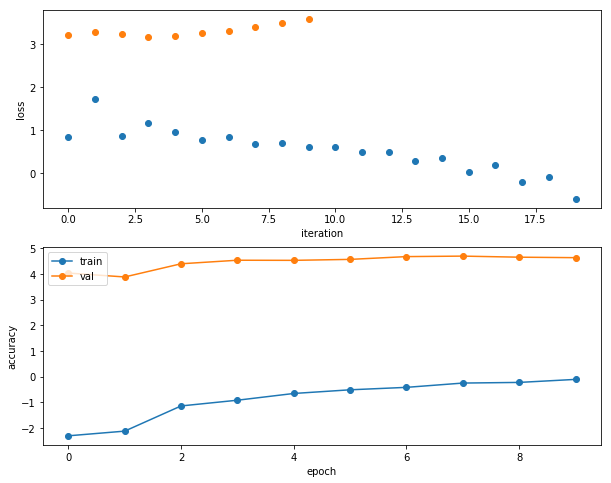

In [83]:
plt.subplot(2, 1, 1)
plt.plot(overfit_solver.train_loss_history, 'o')
plt.plot(overfit_solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(overfit_solver.train_acc_history, '-o')
plt.plot(overfit_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.to()` method to transfer your model onto GPU.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [135]:
from exercise_code.classifiers.classification_cnn import ClassificationCNN
from exercise_code.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

############################################################################
# TODO: Initialize a model and train it using your Solver class. Start     #
# with the previously given set of hyperparameters.                        #
############################################################################
model = ClassificationCNN()
model.to(device)
model_solver = Solver(optim_args={"lr": 1e-4})
model_solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=5)

START TRAIN.
Iteration 100 / 960] Train loss: 2.2529
Iteration 200 / 960] Train loss: 2.0754
Iteration 300 / 960] Train loss: 1.9715
Iteration 400 / 960] Train loss: 1.9102
Iteration 500 / 960] Train loss: 1.8587
Iteration 600 / 960] Train loss: 1.8327
Iteration 700 / 960] Train loss: 1.8081
Iteration 800 / 960] Train loss: 1.7915
Iteration 900 / 960] Train loss: 1.7496
Epoch 1 / 5] Train Accuracy / loss: 0.0005 / 1.7199
Epoch 1 / 5] Val Accuracy / loss: 0.4089 / 0.0353
Iteration 100 / 960] Train loss: 2.0446
Iteration 200 / 960] Train loss: 1.7037
Iteration 300 / 960] Train loss: 1.7019
Iteration 400 / 960] Train loss: 1.6855
Iteration 500 / 960] Train loss: 1.6380
Iteration 600 / 960] Train loss: 1.6511
Iteration 700 / 960] Train loss: 1.6349
Iteration 800 / 960] Train loss: 1.6219
Iteration 900 / 960] Train loss: 1.5967
Epoch 2 / 5] Train Accuracy / loss: 0.0005 / 1.5910
Epoch 2 / 5] Val Accuracy / loss: 0.4546 / 0.0330
Iteration 100 / 960] Train loss: 1.9031
Iteration 200 / 960] Tr

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following. If your kernel visualizations do not exhibit clear structures try optimizing the weight scale:

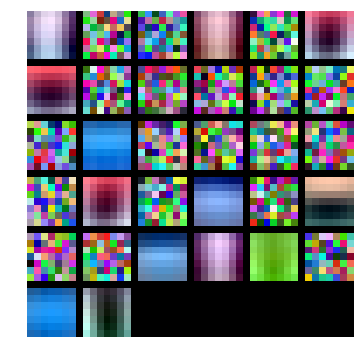

In [136]:
from exercise_code.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).to(device).detach().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [137]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
   
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.518000


## Save the Model

When you are satisfied with your training, you can save the model.

In [138]:
model.save("models/classification_cnn.model")

Saving model... models/classification_cnn.model


In order to complete this task you have to achieve more than __58__ points on the submission website.

## Possible Next Steps

1. Hyperparameter optimization
2. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))
3. Improve your network architecture
    1. Increase network depth
    2. Make network convolutional
    2. Add additional layers such as [Batch normalization](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b#).
